# Predicción de abandono en un gimnasio

Importar librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
sns.set(style="whitegrid")

Cargar el dataset

In [2]:
# Cargar dataset
df = pd.read_csv('gimnasio_knn.csv')
df.head()

,visitas_mes,meses_miembro,uso_clases,edad,cuota_mensual,ABANDONO
0,6,38,5,52,40,0
1,7,25,2,47,50,0
2,6,16,6,67,40,0
3,7,18,5,42,60,0
4,7,1,2,41,60,1


Análisis exploratorio

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   visitas_mes    1800 non-null   int64
 1   meses_miembro  1800 non-null   int64
 2   uso_clases     1800 non-null   int64
 3   edad           1800 non-null   int64
 4   cuota_mensual  1800 non-null   int64
 5   ABANDONO       1800 non-null   int64
dtypes: int64(6)
memory usage: 84.5 KB
Valores nulos:
 visitas_mes      0
meses_miembro    0
uso_clases       0
edad             0
cuota_mensual    0
ABANDONO         0
dtype: int64
Distribución ABANDONO:
 ABANDONO
0    1722
1      78
Name: count, dtype: int64


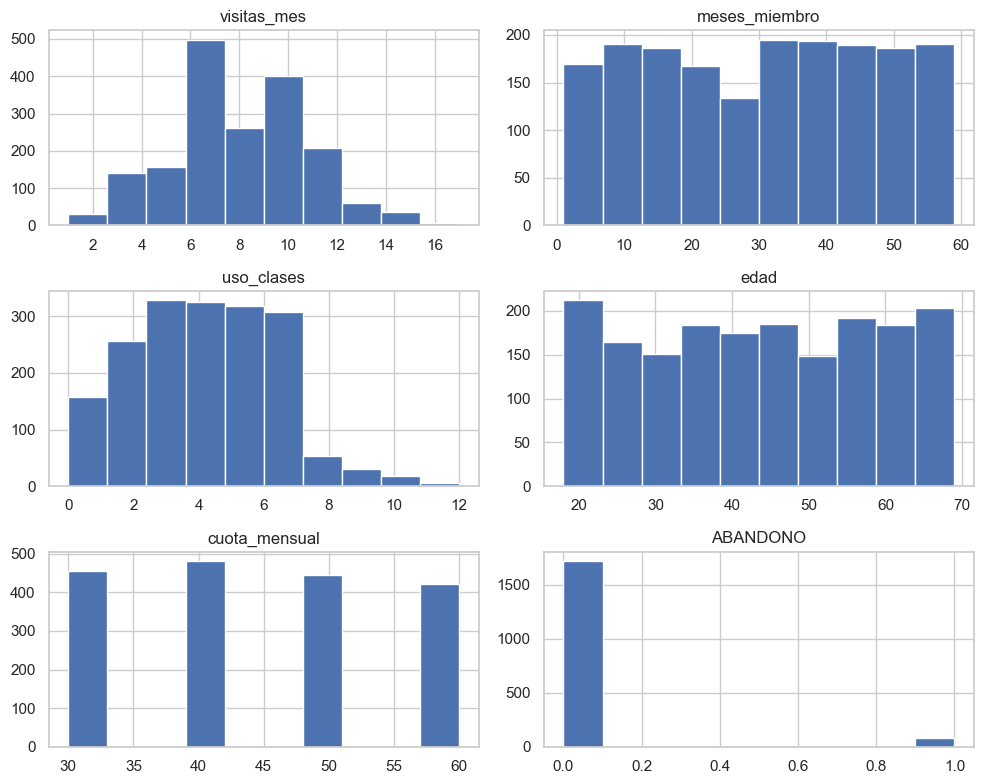

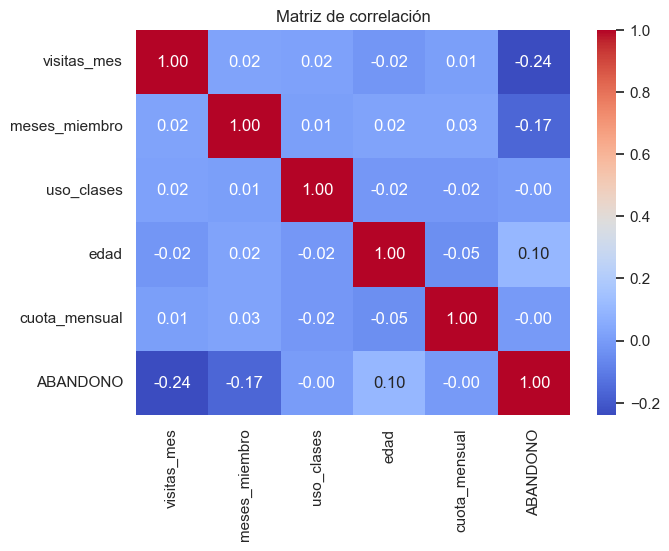

In [3]:
# EDA rápido
df.info()
df.describe().T
print('Valores nulos:\n', df.isnull().sum())
print('Distribución ABANDONO:\n', df['ABANDONO'].value_counts())

# Histogramas
df.hist(figsize=(10,8));
plt.tight_layout()

# Correlación
plt.figure(figsize=(7,5))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de correlación')
plt.show()

Separar variables

In [4]:
# Separar variables
X = df.drop('ABANDONO', axis=1)
y = df['ABANDONO']
X.head()

,visitas_mes,meses_miembro,uso_clases,edad,cuota_mensual
0,6,38,5,52,40
1,7,25,2,47,50
2,6,16,6,67,40
3,7,18,5,42,60
4,7,1,2,41,60


Escalar variables

In [5]:
# Escalar variables numéricas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled.head()

,visitas_mes,meses_miembro,uso_clases,edad,cuota_mensual
0,-0.711366,0.443217,0.429750,0.548156,-0.418340
1,-0.340326,-0.325026,-1.027946,0.215537,0.486723
2,-0.711366,-0.856887,0.915649,1.546011,-0.418340
3,-0.340326,-0.738696,0.429750,-0.117082,1.391785
4,-0.340326,-1.743322,-1.027946,-0.183605,1.391785


Dividir en train/test

In [6]:
# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)
X_train.shape, X_test.shape

((1260, 5), (540, 5))

Entrenar modelo inicial

In [7]:
# Entrenar KNN inicial con k=5
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

Evaluación

Accuracy: 0.9500


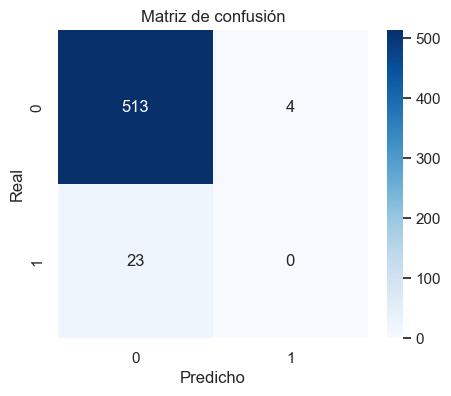

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       517
           1       0.00      0.00      0.00        23

    accuracy                           0.95       540
   macro avg       0.48      0.50      0.49       540
weighted avg       0.92      0.95      0.93       540

ROC AUC: 0.7589


In [8]:
# Evaluación del modelo inicial
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy: {acc:.4f}')

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de confusión')
plt.show()

print(classification_report(y_test, y_pred))

# ROC AUC si es binario
if len(np.unique(y_test)) == 2:
    y_proba = knn.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, y_proba)
    print(f'ROC AUC: {auc:.4f}')

Elegir mejor K

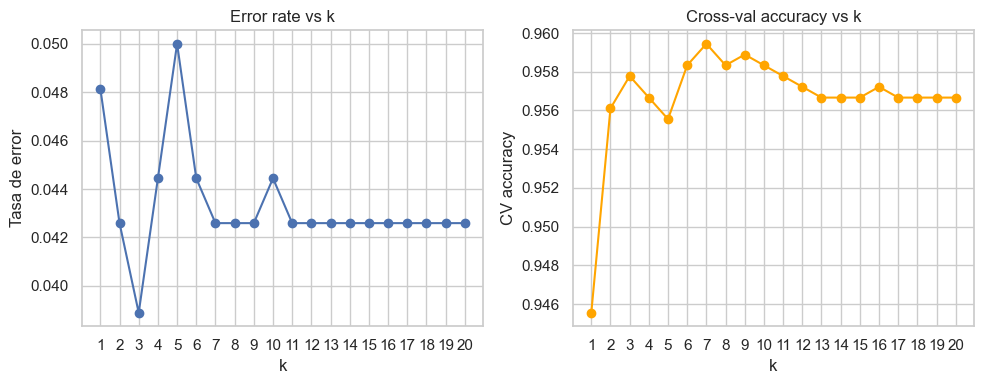

Mejor k por error rate: 3
Mejor k por CV accuracy: 7


In [9]:
# Elegir mejor K: método del codo (error rate) y cross-val
error_rate = []
cv_scores = []
ks = range(1,21)
for k in ks:
    knn_k = KNeighborsClassifier(n_neighbors=k)
    knn_k.fit(X_train, y_train)
    pred_k = knn_k.predict(X_test)
    error = np.mean(pred_k != y_test)
    error_rate.append(error)
    # cross-val accuracy (5-fold)
    scores = cross_val_score(KNeighborsClassifier(n_neighbors=k), X_scaled, y, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(ks, error_rate, marker='o')
plt.xlabel('k')
plt.ylabel('Tasa de error')
plt.title('Error rate vs k')
plt.xticks(ks)

plt.subplot(1,2,2)
plt.plot(ks, cv_scores, marker='o', color='orange')
plt.xlabel('k')
plt.ylabel('CV accuracy')
plt.title('Cross-val accuracy vs k')
plt.xticks(ks)
plt.tight_layout()
plt.show()

best_k = ks[int(np.argmin(error_rate))]
print('Mejor k por error rate:', best_k)
best_k_cv = ks[int(np.argmax(cv_scores))]
print('Mejor k por CV accuracy:', best_k_cv)

Reentrenar con mejor K

Reentrenando con k = 7
Accuracy final: 0.9574074074074074
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       517
           1       0.50      0.04      0.08        23

    accuracy                           0.96       540
   macro avg       0.73      0.52      0.53       540
weighted avg       0.94      0.96      0.94       540



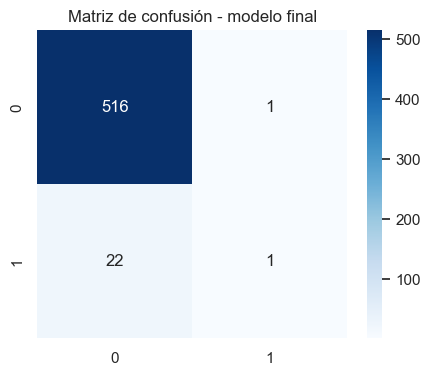

In [10]:
# Reentrenar con mejor k (usar mejor por CV) y evaluar
k_final = best_k_cv if 'best_k_cv' in globals() else best_k
print('Reentrenando con k =', k_final)
knn_final = KNeighborsClassifier(n_neighbors=k_final)
knn_final.fit(X_train, y_train)
y_pred_final = knn_final.predict(X_test)
print('Accuracy final:', accuracy_score(y_test, y_pred_final))
print(classification_report(y_test, y_pred_final))
cmf = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(5,4))
sns.heatmap(cmf, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de confusión - modelo final')
plt.show()